#Step 3
Optimization with uncertain conversion rates

In [1]:
import copy

import numpy as np
import matplotlib.pyplot as plt


import Code.utils as utils
import Code.environment.settings as settings
from Code.environment.Environment import Environment
from Code.GreedyLearner import GreedyLearner
from Code.environment.Customer import Customer
from Code.UCBLearner import UCBLearner
from Code.TSLearner import TSLearner
from Code.NoisyClairvoyant import  NoisyClairvoyant

%matplotlib inline

In [2]:
cust_json = "customer3.json"
today_customer = 100
var_cust = 1
p_lambda = 1.0
graph_json = "business_full_graph2_sparse.json"
arms = settings.prices

environment = Environment(cust_json,today_customer,var_cust,p_lambda, graph_json, arms)

clairvoyant_arms, clairvoyant_reward, exp_c, rew_per_arm= environment.estimate_clairvoyant()

print("\n", clairvoyant_arms, clairvoyant_reward, exp_c)

loading: [                              ] 0.0%
loading: [=                             ] 1.0%
loading: [=                             ] 2.0%
loading: [=                             ] 2.9%
loading: [==                            ] 3.9%
loading: [==                            ] 4.9%
loading: [==                            ] 5.9%
loading: [===                           ] 6.8%
loading: [===                           ] 7.8%
loading: [===                           ] 8.8%
loading: [===                           ] 9.8%
loading: [====                          ] 10.7%
loading: [====                          ] 11.7%
loading: [====                          ] 12.7%
loading: [=====                         ] 13.7%
loading: [=====                         ] 14.6%
loading: [=====                         ] 15.6%
loading: [=====                         ] 16.6%
loading: [======                        ] 17.6%
loading: [======                        ] 18.6%
loading: [======                        ] 19.5%
loa

In [3]:
n_arms = 4
n_products = 5 

TIME_HORIZON = 300
NUM_ITERATION = 5

In [4]:
customers = copy.deepcopy(environment.customers)
for customer in customers:
    customer.set_probability_buy(np.ones_like(customer.get_buy_distribution())/2)

UCB

In [5]:
ucb_rewards_iterations = []
for i in range(NUM_ITERATION):
    ucb1_learner = UCBLearner(n_arms, n_products, customers, graph_json, arms, environment.customers_distribution)
    print('Iteration #', i+1)
    for t in range(TIME_HORIZON):
        if t % 10 == 0:
            utils.progress_bar(t, TIME_HORIZON)
        ucb_super_arm = ucb1_learner.select_superarm()
        report = environment.round(ucb_super_arm)
        ucb1_learner.update(ucb_super_arm.copy(), report)
    ucb_rewards = ucb1_learner.history_rewards
    ucb_rewards_iterations.append(np.array(ucb_rewards))
ucb_rewards_iterations = np.array(ucb_rewards_iterations)
ucb_rewards_iterations.shape

Iteration # 1
loading: [                              ] 0.0%
loading: [=                             ] 3.3%
loading: [==                            ] 6.7%
loading: [===                           ] 10.0%
loading: [====                          ] 13.3%
loading: [=====                         ] 16.7%
loading: [======                        ] 20.0%
loading: [=======                       ] 23.3%
loading: [========                      ] 26.7%
loading: [=========                     ] 30.0%
loading: [==========                    ] 33.3%
loading: [===========                   ] 36.7%
loading: [============                  ] 40.0%
loading: [=============                 ] 43.3%
loading: [==============                ] 46.7%
loading: [===============               ] 50.0%
loading: [================              ] 53.3%
loading: [=================             ] 56.7%
loading: [==================            ] 60.0%
loading: [===================           ] 63.3%
loading: [===================

(5, 300)

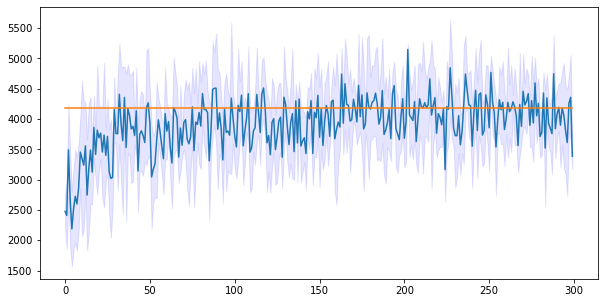

In [6]:
plt.figure(figsize=(10, 5))
mean = np.mean(ucb_rewards_iterations, axis=0)
stdev = np.std(ucb_rewards_iterations, axis=0)

plt.plot(range(len(mean)), mean)
plt.fill_between(range(len(mean)), (mean-stdev), (mean+stdev), color='b', alpha=.1)

plt.plot([_ for _ in range(len(ucb_rewards))], [clairvoyant_reward for _ in range(len(ucb_rewards))])
plt.show()

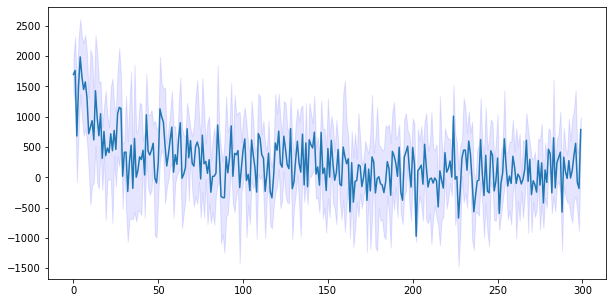

In [7]:
plt.figure(figsize=(10,5))
ucb_regret = clairvoyant_reward - ucb_rewards_iterations 
ucb_mean_regret = np.mean(ucb_regret, axis=0)
ucb_stdev_regret = np.std(ucb_rewards_iterations, axis=0)

plt.plot(range(len(ucb_mean_regret)), ucb_mean_regret)
plt.fill_between(range(len(ucb_mean_regret)), (ucb_mean_regret-ucb_stdev_regret), (ucb_mean_regret+ucb_stdev_regret), color='b', alpha=.1)
plt.show()

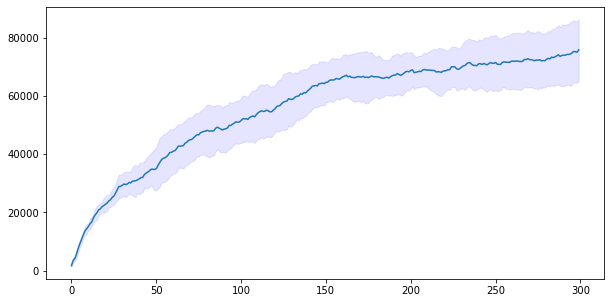

In [8]:
plt.figure(figsize=(10,5))
ucb_regret = clairvoyant_reward - ucb_rewards_iterations 
ucb_cumulative_regret = np.cumsum(ucb_regret, axis=1)
ucb_cum_reg_mean = np.mean(ucb_cumulative_regret, axis=0)
ucb_cum_reg_stdev = np.std(ucb_cumulative_regret, axis=0)

plt.plot(range(len(ucb_cum_reg_mean)), ucb_cum_reg_mean)
plt.fill_between(range(len(ucb_cum_reg_mean)), (ucb_cum_reg_mean-ucb_cum_reg_stdev), (ucb_cum_reg_mean+ucb_cum_reg_stdev), color='b', alpha=.1)

plt.show()

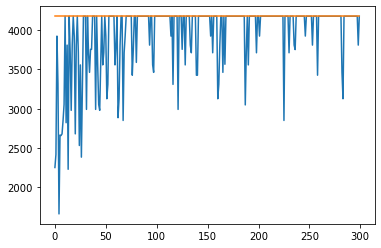

In [9]:
ucb_pulled_arms = ucb1_learner.get_all_pulled()
theoretical_rewards = [rew_per_arm[tuple(i)] for i in ucb_pulled_arms]

plt.plot([i for i in range(len(ucb_pulled_arms))], theoretical_rewards)
plt.plot([_ for _ in range(len(ucb_rewards))], [clairvoyant_reward for _ in range(len(ucb_rewards)) ])
plt.show()


TS

In [10]:
ts_rewards_iterations = []
for i in range(NUM_ITERATION):
    ts_learner = TSLearner(n_arms, n_products, customers, graph_json, arms, environment.customers_distribution)
    print('\nIteration #', i+1)
    for t in range(TIME_HORIZON):
        if t % 10 == 0:
            utils.progress_bar(t, TIME_HORIZON)
        ts_super_arm = ts_learner.select_superarm()
        report = environment.round(ts_super_arm)
        ts_learner.update(ts_super_arm.copy(), report)
    ts_rewards = ts_learner.history_rewards
    ts_rewards_iterations.append(np.array(ts_rewards))
ts_rewards_iterations = np.array(ts_rewards_iterations)
ts_rewards_iterations.shape


Iteration # 1
loading: [                              ] 0.0%
loading: [=                             ] 3.3%
loading: [==                            ] 6.7%
loading: [===                           ] 10.0%
loading: [====                          ] 13.3%
loading: [=====                         ] 16.7%
loading: [======                        ] 20.0%
loading: [=======                       ] 23.3%
loading: [========                      ] 26.7%
loading: [=========                     ] 30.0%
loading: [==========                    ] 33.3%
loading: [===========                   ] 36.7%
loading: [============                  ] 40.0%
loading: [=============                 ] 43.3%
loading: [==============                ] 46.7%
loading: [===============               ] 50.0%
loading: [================              ] 53.3%
loading: [=================             ] 56.7%
loading: [==================            ] 60.0%
loading: [===================           ] 63.3%
loading: [==================

(5, 300)

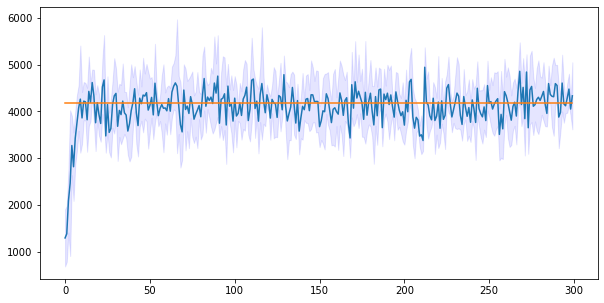

In [11]:
plt.figure(figsize=(10,5))
mean = np.mean(ts_rewards_iterations, axis=0)
stdev = np.std(ts_rewards_iterations, axis=0)

plt.plot(range(len(mean)), mean)
plt.fill_between(range(len(mean)), (mean-stdev), (mean+stdev), color='b', alpha=.1)

plt.plot([_ for _ in range(len(ts_rewards))], [clairvoyant_reward for _ in range(len(ts_rewards))])
plt.show()

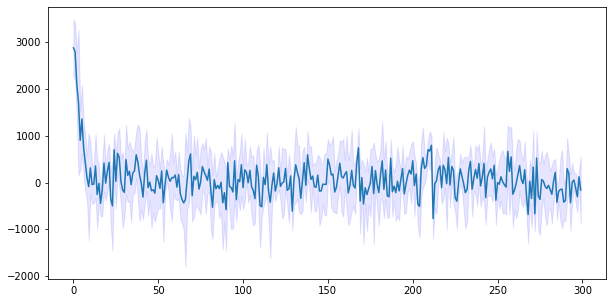

In [12]:
plt.figure(figsize=(10,5))
ts_regret = clairvoyant_reward - ts_rewards_iterations 
ts_mean_regret = np.mean(ts_regret, axis=0)
ts_reg_stdev = np.std(ts_regret, axis=0)

plt.plot(range(len(ts_mean_regret)), ts_mean_regret)
plt.fill_between(range(len(ts_mean_regret)), (ts_mean_regret-ts_reg_stdev), (ts_mean_regret+ts_reg_stdev), color='b', alpha=.1)
plt.show()

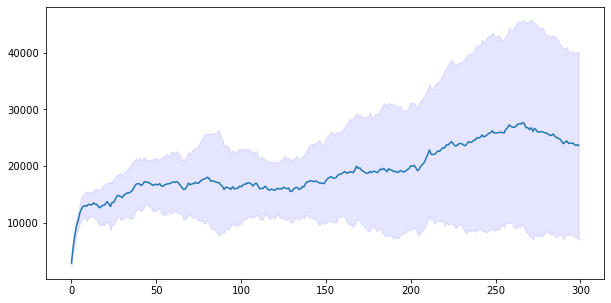

In [13]:
plt.figure(figsize=(10,5))
ts_regret = clairvoyant_reward - ts_rewards_iterations 
ts_cumulative_regret = np.cumsum(ts_regret, axis=1)
ts_cum_reg_mean = np.mean(ts_cumulative_regret, axis=0)
ts_cum_reg_stdev = np.std(ts_cumulative_regret, axis=0)

plt.plot(range(len(ts_cum_reg_mean)), ts_cum_reg_mean)
plt.fill_between(range(len(ts_cum_reg_mean)), (ts_cum_reg_mean-ts_cum_reg_stdev), (ts_cum_reg_mean+ts_cum_reg_stdev), color='b', alpha=.1)
plt.show()

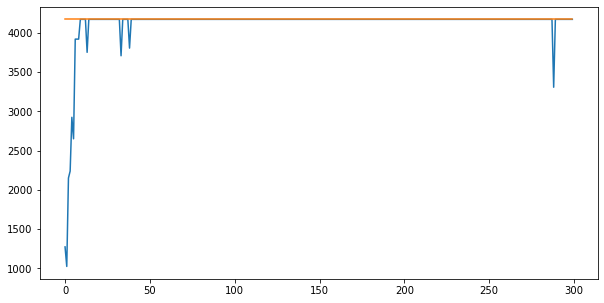

In [14]:
ts_pulled_arms = ts_learner.get_all_pulled()
theoretical_rewards = [rew_per_arm[tuple(i)] for i in ts_pulled_arms]

plt.figure(figsize=(10,5))
plt.plot([i for i in range(len(ts_pulled_arms))], theoretical_rewards)
plt.plot([_ for _ in range(len(ts_rewards))], [clairvoyant_reward for _ in range(len(ts_rewards)) ])
plt.show()


In [15]:
th_rews = list(rew_per_arm.values())
th_rews.sort()
delta_arms = (th_rews[-1] - th_rews[-2]) / today_customer
seen = np.cumsum(ts_learner.history_interactions)
theoretical_regret = 1024 * np.log(seen)/delta_arms

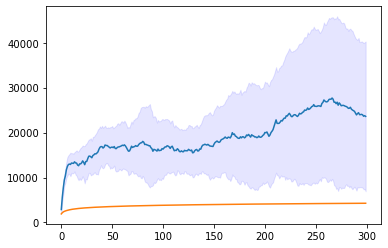

In [16]:
plt.plot(range(len(ts_cum_reg_mean)), ts_cum_reg_mean)
plt.fill_between(range(len(ts_cum_reg_mean)), (ts_cum_reg_mean-ts_cum_reg_stdev), (ts_cum_reg_mean+ts_cum_reg_stdev), color='b', alpha=.1)
plt.plot(range(len(theoretical_regret)), theoretical_regret)
plt.show()